In [8]:
import cv2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [9]:
# all_images = os.listdir('combined_faces/')
ranges = ['1-2','3-9','10-20','21-27','28-45','46-65','66-116']

# X = []
# y = []

# l = len(all_images)

# for a in range(l):
#     X.append(cv2.imread(f'combined_faces/{all_images[a]}',0))
#     age = int(all_images[a].split('_')[0])
    
#     if age>=1 and age<=2:
#         y.append(0)
#     elif age>=3 and age<=9:
#         y.append(1)
#     elif age>=10 and age<=20:
#         y.append(2)
#     elif age>=21 and age<=27:
#         y.append(3)
#     elif age>=28 and age<=45:
#         y.append(4)
#     elif age>=46 and age<=65:
#         y.append(5)
#     elif age>=66 and age<=116:
#         y.append(6)
#     print(str(a)+'/'+str(l))

# np.savez_compressed('compressed image data.npz',x=X,y=y)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ls drive/MyDrive/

 certificates		     'Major Synopsis.docx'
'Colab Notebooks'	      resume
'compressed image data.npz'  'stripe 2step.gdoc'
 contact.gdoc		     'stripe live secret key.gdoc'
 docs			      study
'Graphics Parlour'	      UpdraftPlus


In [12]:
loaded = np.load('compressed image data.npz')

X = loaded['x']
y = loaded['y']

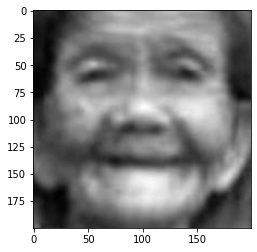

In [13]:
plt.imshow(X[0],cmap='gray')

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
from keras.utils import np_utils

y = np_utils.to_categorical(y)

In [16]:
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
X_train = np.array(X_train).reshape(-1,200,200,1)

In [19]:
X_test = np.array(X_test).reshape(-1,200,200,1)

In [20]:
IMG_HEIGHT = 200
IMG_WIDTH = 200
IMG_SIZE = (IMG_HEIGHT,IMG_WIDTH)
batch_size = 128
epochs = 60

In [21]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   rotation_range=15)

test_datagen = ImageDataGenerator(rescale=1./255)

In [22]:
train_data = train_datagen.flow(X_train,y_train,batch_size)

test_data = test_datagen.flow(X_test,y_test,batch_size)

In [23]:
final_cnn = Sequential()

final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))

final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))


final_cnn.add(GlobalAveragePooling2D())

final_cnn.add(Dense(132, activation='relu'))

final_cnn.add(Dense(7, activation='softmax'))

final_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
average_pooling2d_2 (Average (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 256)       2

In [24]:
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
checkpoint = ModelCheckpoint(filepath="models/final_cnn_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

In [26]:
history = final_cnn.fit(train_data,
                    batch_size=512,
                    validation_data=test_data,
                    epochs=60,
                    callbacks=[checkpoint],
                    shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                    ) 

Epoch 1/60
184/184 [==============================] - 132s 543ms/step - loss: 1.8093 - accuracy: 0.2806 - val_loss: 1.7599 - val_accuracy: 0.2984

Epoch 00001: val_accuracy improved from -inf to 0.29839, saving model to final_cnn_model_checkpoint.h5
Epoch 2/60
184/184 [==============================] - 99s 536ms/step - loss: 1.7372 - accuracy: 0.3137 - val_loss: 1.7212 - val_accuracy: 0.3277

Epoch 00002: val_accuracy improved from 0.29839 to 0.32766, saving model to final_cnn_model_checkpoint.h5
Epoch 3/60
184/184 [==============================] - 98s 533ms/step - loss: 1.7039 - accuracy: 0.3270 - val_loss: 1.6727 - val_accuracy: 0.3406

Epoch 00003: val_accuracy improved from 0.32766 to 0.34060, saving model to final_cnn_model_checkpoint.h5
Epoch 4/60
184/184 [==============================] - 98s 534ms/step - loss: 1.6631 - accuracy: 0.3429 - val_loss: 1.6088 - val_accuracy: 0.3584

Epoch 00004: val_accuracy improved from 0.34060 to 0.35842, saving model to final_cnn_model_checkpoi

In [27]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

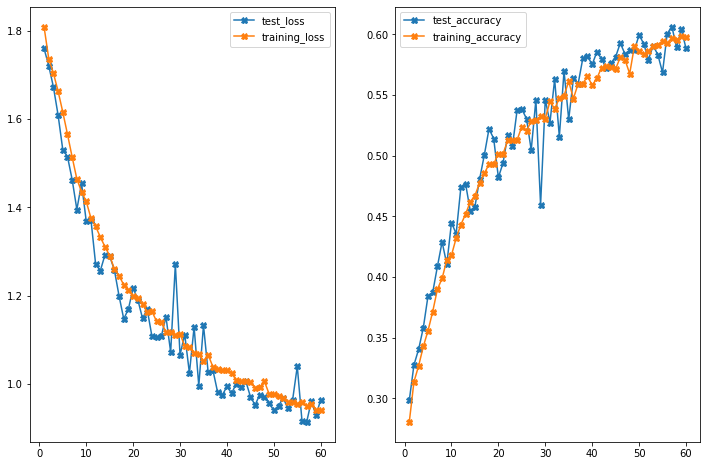

In [31]:
plotting_data_dict = history.history

plt.figure(figsize=(12,8))

test_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
test_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']

epochs = range(1,len(test_loss)+1)

plt.subplot(121)
plt.plot(epochs,test_loss,marker='X',label='test_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs,test_accuracy,marker='X',label='test_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()

plt.savefig('training.png')